# Traffic prediction - machine learning models (regression)

Robert Kowalczyk 397108  
Jarosław Leski 411174

# 1. Prepare necessary libraries

In [79]:
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",100)

# Data wrangling
import pandas as pd
import numpy as np
from datetime import datetime as dt 

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

# Modelling with scikit-learn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
import optuna
import sklearn



# 2. Loading data and cleaning

Your task is to apply various ML algorithms (see the rules below) to build a model **explaining the traffic** on one of the highways for one-hourly intervals based on the **training sample** and generate predictions for **all observations** from the **test sample**.

The dataset includes the following columns:

* _date_time_ – date and time (1 hourly interval)
* _weather_general_ – general short description of the current weather with the following levels: Clear, Clouds, Drizzle, Fog, Haze, Mist, Rain, Smoke, Snow, Squall, Thunderstorm
* _weather_detailed_ – more detailed description of the current weather with the following levels: broken clouds, drizzle, few clouds, fog, freezing rain, haze, heavy intensity drizzle, heavy intensity rain, heavy snow, light intensity drizzle, light intensity shower rain, light rain, light rain and snow, light shower snow, light snow, mist, moderate rain, overcast clouds, proximity shower rain, proximity thunderstorm, proximity thunderstorm with drizzle, proximity thunderstorm with rain, scattered clouds, shower drizzle, shower snow, sky is clear, sleet, smoke, snow, squalls, thunderstorm, thunderstorm with drizzle, thunderstorm with heavy rain, thunderstorm with light drizzle, thunderstorm with light rain, thunderstorm with rain, very heavy rain
* _clouds_coverage_ – percentage of sky covered by the clouds in the hourly interval
* _temperature_ – average temperature in the hourly interval (in Celsius degrees)
* _rain_mm_ – amount of rain that occurred in the hourly interval (in mm)
* _snow_mm_ – amount of snow that occurred in the hourly interval (in mm)
* _traffic_ – the amount of traffic in the hourly interval (outcome variable)

Let's load the data and look at the first five observations

In [80]:
traffic = pd.read_csv('traffic_train.csv')

traffic.head()

,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
0,2014-10-01 00:00:00,Clear,sky is clear,1,11.5,0.0,0.0,508
1,2014-10-01 01:00:00,Clear,sky is clear,1,10.3,0.0,0.0,323
2,2014-10-01 02:00:00,Clear,sky is clear,1,8.0,0.0,0.0,274
3,2014-10-01 03:00:00,Clear,sky is clear,1,7.9,0.0,0.0,372
4,2014-10-01 04:00:00,Clear,sky is clear,1,6.4,0.0,0.0,812


In [81]:
traffic.describe()

,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
count,29701.000000,29701.000000,29701.000000,29701.000000,29701.000000
mean,50.210027,7.500451,0.509914,0.000361,3228.196761
std,38.657342,13.769115,57.058322,0.010403,1989.059081
min,0.000000,-273.100000,0.000000,0.000000,0.000000
25%,1.000000,-1.300000,0.000000,0.000000,1159.000000
50%,64.000000,8.300000,0.000000,0.000000,3309.000000
75%,90.000000,18.300000,0.000000,0.000000,4918.000000
max,100.000000,35.100000,9831.300000,0.510000,7263.000000


In the training set we noticed two very interesting situations:

- _temperature_ variable contains a minimum value of -273.1 degrees celsius, which we believe is an incorrect value. This value is equal to absolute zero, and there are no places on Earth with a similar temperature (possibly in the laboratory by laser cooling of molecules). This is rather an error in the reading by the sensor and we intend to replace for these observations the value of the average for the month in which this occurred, 
- _rain_mm_ variable contains an outlier observation equal to 9831.3, which, compared to the mean of 0.51, can strongly influence the estimation of the models. To do this, we replace this observation with the second maximum value for this set.



In [82]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29701 entries, 0 to 29700
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time            29701 non-null  object 
 1   weather_general      29701 non-null  object 
 2   weather_detailed     29701 non-null  object 
 3   clouds_coverage_pct  29701 non-null  int64  
 4   temperature          29701 non-null  float64
 5   rain_mm              29701 non-null  float64
 6   snow_mm              29701 non-null  float64
 7   traffic              29701 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 1.8+ MB


In [85]:
char_cols = traffic.select_dtypes(include=['object'])
char_cols = char_cols.drop('date_time', axis = 1)
for col in char_cols:
    print(col, ':', char_cols[col].value_counts())

weather_general : Clouds          10164
Clear            8030
Rain             3560
Mist             3491
Snow             1794
Drizzle           920
Haze              743
Thunderstorm      497
Fog               481
Smoke              17
Squall              4
Name: weather_general, dtype: int64
weather_detailed : sky is clear                           8030
mist                                   3491
overcast clouds                        3491
broken clouds                          3130
light rain                             2248
scattered clouds                       2044
few clouds                             1499
light snow                             1046
moderate rain                           966
haze                                    743
heavy snow                              581
light intensity drizzle                 551
fog                                     481
drizzle                                 337
proximity thunderstorm                  311
heavy intensity rain     

In our dataset, we do not notice any missing data in all columns, so we do not involve any algorithm to impute missing data

## Data Transformations

In our analysis of traffic jams in the city, we wanted to extract as much information as possible from the proposed variables. 
We decided to extract information from the primary variables as follows:
- _date_time_ -> From this variable we extracted information about the _year_, _month_, _day_ of the week and _hour_. We decided not to decode each hour into a zero-one variable, but to make 6 hour intervals dividing our day into 4 equal parts. This is justified because for these 4 parts the traffic variable differs significantly due to sleeping hours and working and commuting hours. Additionally, we decided to add a variable informing whether it is currently the weekend. 
- _weather_detailed_ -> For this variable, we considered to create an ordinal variable from the presented descriptions of the atmospheric phenomena observed on the road. We established 4 levels (from the worst conditions to sufficiently favourable conditions). Level 0 means fatal conditions, 1 poor, 2 moderate and 3 good.
- _weather_general_ -> For this nominal variable, we decoded all levels into zero-one variables and checked which weather types have a variance close to zero. For such variables we attached them to other equally thematically similar categories (Smoke -> Fog and Squall -> Rain)

In [86]:
def dayFromDate(traffic):
    traffic['date_time'] = pd.to_datetime(traffic['date_time'])
    traffic['hour'] = traffic.date_time.dt.hour
    traffic['hour_interval'] = pd.cut(traffic.hour, bins = [-1,6,12,18,24], labels = ['0-6','6-12', '12-18', '18-24'])
    
    
    
    traffic['day'] = traffic.date_time.dt.day_of_week 
    
    traffic['is_weekend'] = np.where(traffic.day.isin([5, 6]), 1, 0)
    traffic['month'] = traffic.date_time.dt.month

    traffic['tmp'] = range(0,len(traffic.hour))
    traffic['year'] = traffic.date_time.dt.year
    t1 = pd.get_dummies(traffic['month'])
    t1['tmp'] = range(0,len(traffic.month))
    traffic = pd.merge(traffic, t1, on = ['tmp'])

    t1 = pd.get_dummies(traffic['hour_interval'])
    t1['tmp'] = range(0,len(traffic.hour))
    traffic = pd.merge(traffic, t1, on = ['tmp'])

    t1 = pd.get_dummies(traffic['hour'])
    t1['tmp'] = range(0,len(traffic.hour))
    traffic = pd.merge(traffic, t1, on = ['tmp'])

    t1 = pd.get_dummies(traffic['day'])
    t1['tmp'] = range(0,len(traffic.hour))
    traffic = pd.merge(traffic, t1, on = ['tmp']).drop(columns = ['tmp'])
    return(traffic)

def ordinal_whether(traffic):
    traffic['ordinal_weather'] = np.where(traffic.weather_detailed.isin(['fog', 'freezing rain', 'heavy intensity rain','heavy snow','proximity thunderstorm',
                                 'proximity thunderstorm with drizzle', 'proximity thunderstorm with rain', 'sleet', 'squalls',
                                 'thunderstorm', 'thunderstorm with drizzle', 'thunderstorm with heavy rain', 'thunderstorm with light drizzle',
                                  'thunderstorm with light rain', 'thunderstorm with rain', 'very heavy rain']), 0, #fatal
                                 np.where(traffic.weather_detailed.isin(['drizzle','haze', 'heavy intensity drizzle','light intensity drizzle','light intensity shower rain',
                                 'light rain', 'light rain and snow', 'light shower snow', 'light snow','mist', 'moderate rain', 'shower drizzle',
                                  'shower snow', 'smoke', 'snow', ]), 1, #poor
                                 np.where(traffic.weather_detailed.isin(['broken clouds','few clouds', 'overcast clouds', 'proximity shower rain',
                                 ]), 2, #moderate
                                 np.where(traffic.weather_detailed.isin(['scattered clouds', 'sky is clear', ]), 3, 99 )))) #good
    return (traffic)
    
def weather_dummies(traffic):
    t1 = pd.get_dummies(traffic['weather_general'])
    t1['tmp'] = range(0,len(traffic.weather_detailed))
    traffic['tmp'] = range(0,len(traffic.weather_detailed))
    traffic = pd.merge(traffic, t1, on = ['tmp'])
    traffic['Fog'] = traffic['Fog'] + traffic['Smoke']
    traffic['Rain'] = traffic['Rain'] + traffic['Squall']
    traffic = traffic.drop(columns = ['Smoke', 'Squall', 'tmp']) 
    return(traffic)

def weather_dummies_test(traffic):
    t1 = pd.get_dummies(traffic['weather_general'])
    t1['tmp'] = range(0,len(traffic.weather_detailed))
    traffic['tmp'] = range(0,len(traffic.weather_detailed))
    traffic = pd.merge(traffic, t1, on = ['tmp'])
    traffic['Fog'] = traffic['Fog'] + traffic['Smoke']
    traffic['Rain'] = traffic['Rain'] #+ traffic['Squall']
    traffic = traffic.drop(columns = ['Smoke',  'tmp']) # 'Squall',
    return(traffic)

def outliers_correction(traffic):

    traffic.temperature.loc[(traffic.temperature < -30)] = traffic.groupby(by = ['month']).mean().temperature[1]
    traffic.rain_mm.loc[traffic.rain_mm > 1000] = traffic.rain_mm.loc[traffic.rain_mm < 1000].max()
    return (traffic)



## Outliers detection

As we mentioned earlier for the variables temperature and rain_mm we probably observed errors in the readings. As far as temperature is concerned, for these outlier observations we replaced their mean values for the month in which these readings occurred. For rain_mm we replaced the outlier with the second largest observation in the set. 

# 3. Exploanatory Data Analysis

Let's create a time series for the variable traffic for the first 200 observations. 

We can see that for this variable we have a very visible seasonality, which to a large extent certainly depends on the hour in which the traffic was recorded. 

<AxesSubplot:>

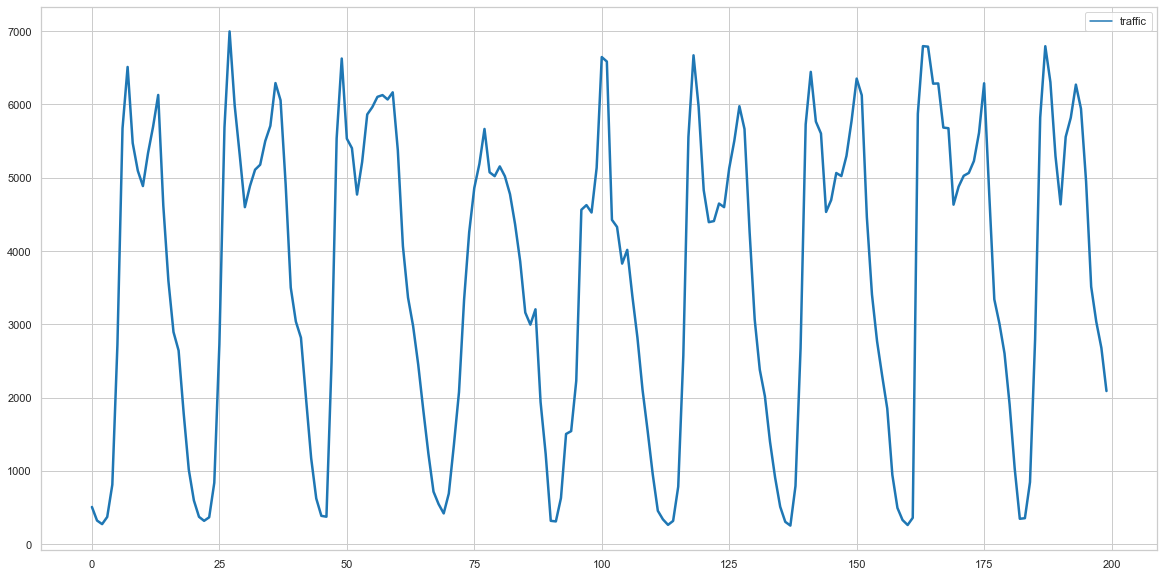

In [87]:
sns.set(rc = {'figure.figsize':(20,10)})
sns.set_theme(style="whitegrid")
temp_traffic = traffic[['date_time', 'traffic']]
temp_traffic['date_time'] = pd.to_datetime(temp_traffic['date_time'])
sns.lineplot(data=temp_traffic[:200],  palette="tab10", linewidth=2.5)

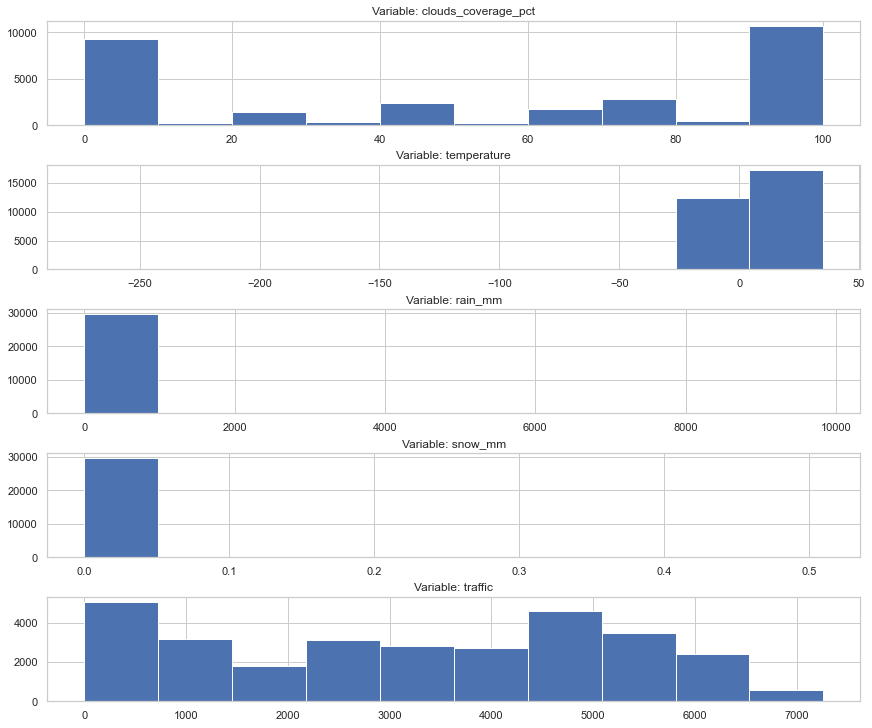

In [88]:
numericalVar = ['clouds_coverage_pct', 'temperature', 'rain_mm', 'snow_mm', 'traffic']
fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(12, 10),
                        constrained_layout=True)
for idx, col in enumerate(numericalVar):
    axs[idx].hist(traffic[f'{col}'])
    axs[idx].set_title(f'Variable: {col}')
    


Above you can see the histograms for the numerical variables before correction for outlier observations. Unfortunately, normal distributions are not visible at first glance. In addition, the variables rain_mm and snow_mm are highly concentrated around the value 0.

Let us now perform all the transformations of the variables and the correction of outlier observations. 

In [89]:
# functions = [dayFromDate(traffic), ordinal_whether(traffic), weather_dummies(traffic), outliers_correction(traffic)]

traffic = dayFromDate(traffic)
traffic = ordinal_whether(traffic)
traffic = weather_dummies(traffic)
traffic = outliers_correction(traffic)


Let us now perform all the transformations of the variables and the correction of outlier observations. In addition, encoding variables spoils the naming of variables, so it is worth manually changing them to more understandable ones. 

In [90]:
traffic.rename(columns={'1_x':'January', '2_x':'February', '3_x':'March', '4_x':'April',
                       '5_x':'May','6_x':'June','7_x':'July', '8_x':'August','9_x':'September',
                       '10_x':'November', '11_x':'October', '12_x':'December', '0_x':'Hour_0',
                       '1_y':'Hour_1','2_y':'Hour_2','3_y':'Hour_3','4_y':'Hour_4',
                       '5_y':'Hour_5','6_y':'Hour_6','7_y':'Hour_7','8_y':'Hour_8',
                       '9_y':'Hour_9','10_y':'Hour_10','11_y':'Hour_11','12_y':'Hour_12',
                       13:'Hour_13',14:'Hour_14',15:'Hour_15',16:'Hour_16',
                       17:'Hour_17',18:'Hour_18',19:'Hour_19',20:'Hour_20',
                       21:'Hour_21',22:'Hour_22',23:'Hour_23','0_y':'Monday',
                       1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}, inplace=True)

## Corrplot

Let's start by creating a correlation matrix.  
Only few of the variables are highly correlated with each other (assumed threshold >|0.7|).  
In particular, it is good information that the predicted variable has only very weak correlation coefficients.  

In [91]:
corr = traffic.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')
 .set_precision(2))

,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic,hour,day,is_weekend,month,year,January,February,March,April,May,June,July,August,September,November,October,December,0-6,6-12,12-18,18-24,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,ordinal_weather,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Snow,Thunderstorm
clouds_coverage_pct,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
temperature,-0.17,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
rain_mm,0.09,0.10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
snow_mm,0.04,-0.03,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
traffic,0.04,0.13,-0.03,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
hour,0.02,0.11,-0.02,0.01,0.35,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
day,-0.02,-0.00,-0.01,-0.02,-0.16,-0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
is_weekend,-0.03,-0.00,0.01,-0.02,-0.23,-0.01,0.79,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
month,-0.02,0.13,0.00,0.02,-0.03,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
year,-0.10,0.21,0.02,0.02,-0.02,-0.01,-0.01,-0.01,-0.04,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


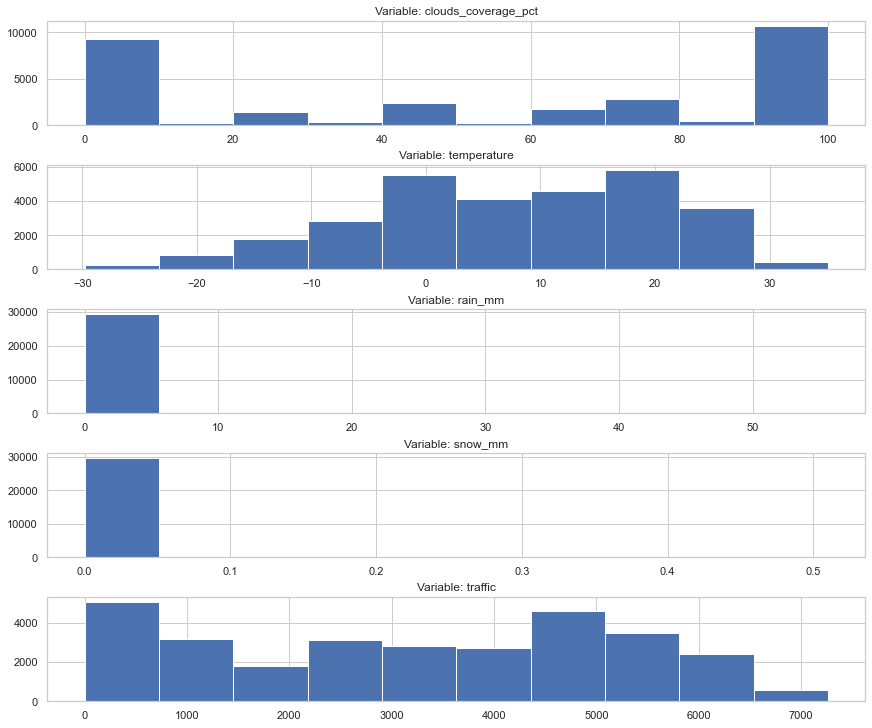

In [92]:
fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(12, 10),
                        constrained_layout=True)
for idx, col in enumerate(numericalVar):
    axs[idx].hist(traffic[f'{col}'])
    axs[idx].set_title(f'Variable: {col}')

After the applied changes on the data and the removal of outlier observations, the distributions of the analysed variables can be seen much better. However, still the variables rain_mm and snow_mm oscillate around zero, which means that they may not be significant variables.

## Violin plots

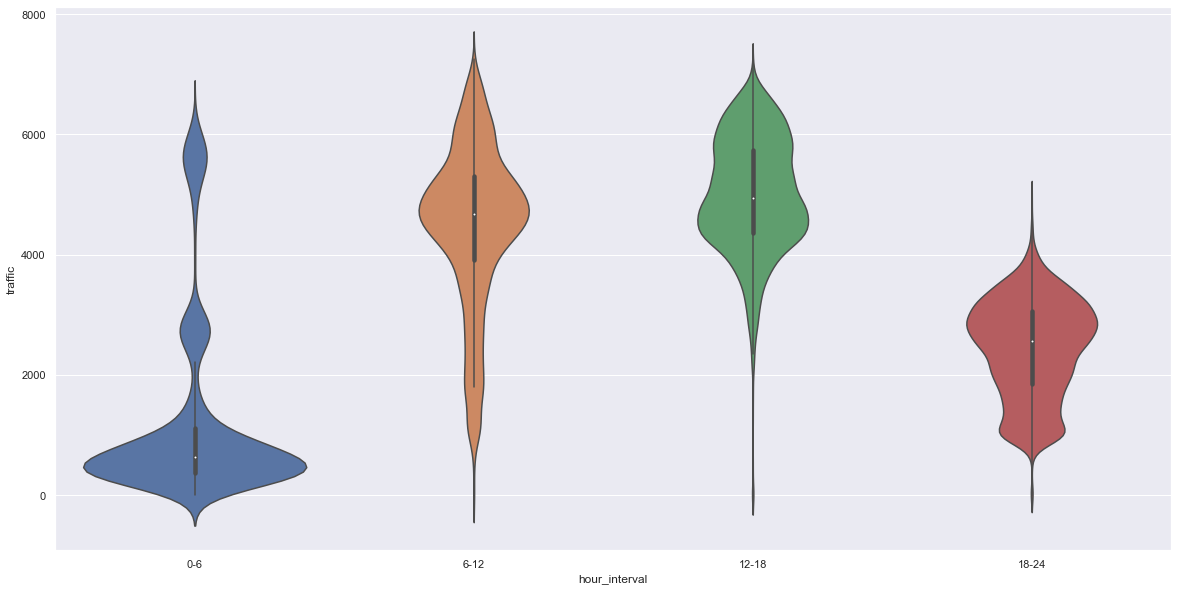

In [93]:
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.violinplot(x = traffic.hour_interval, y = traffic.traffic)

Let's look at the distribution of the traffic variable according to the hourly interval used. It is clear that there is much less traffic on the road at night and in the evening than during working hours. This variable can have a significant impact on the modelling. 

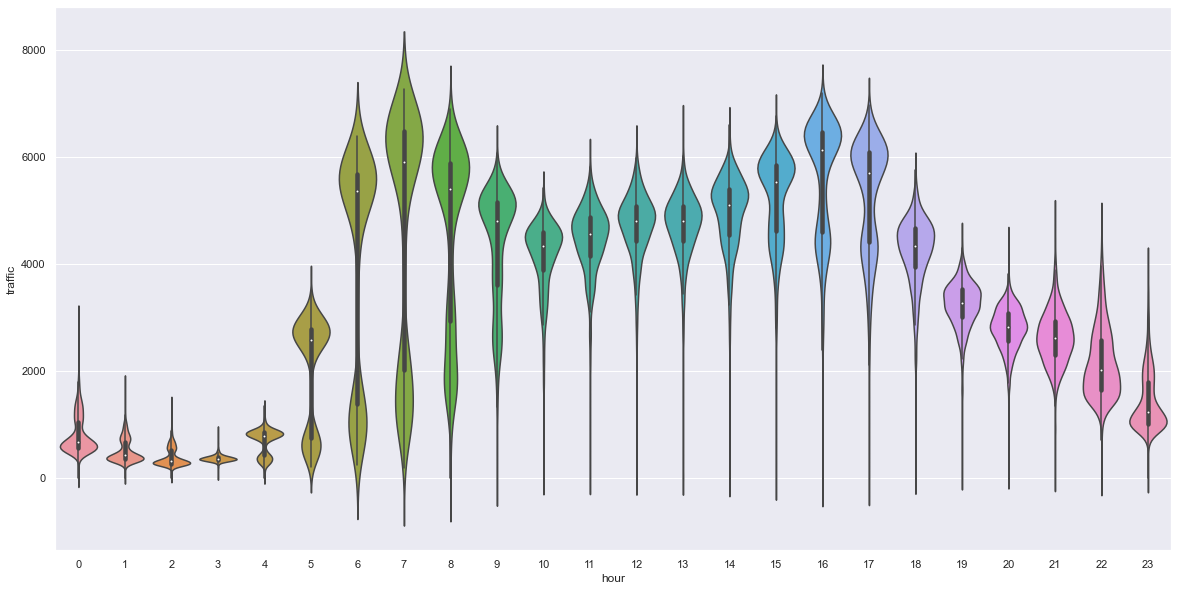

In [94]:
ax = sns.violinplot(x = traffic.hour, y = traffic.traffic, scale = "width")

A more accurate view of the traffic variable can be seen for exact times. We can see a huge upward trend in the hours when work starts and when work ends. However, during the night hours traffic decreases accordingly. 

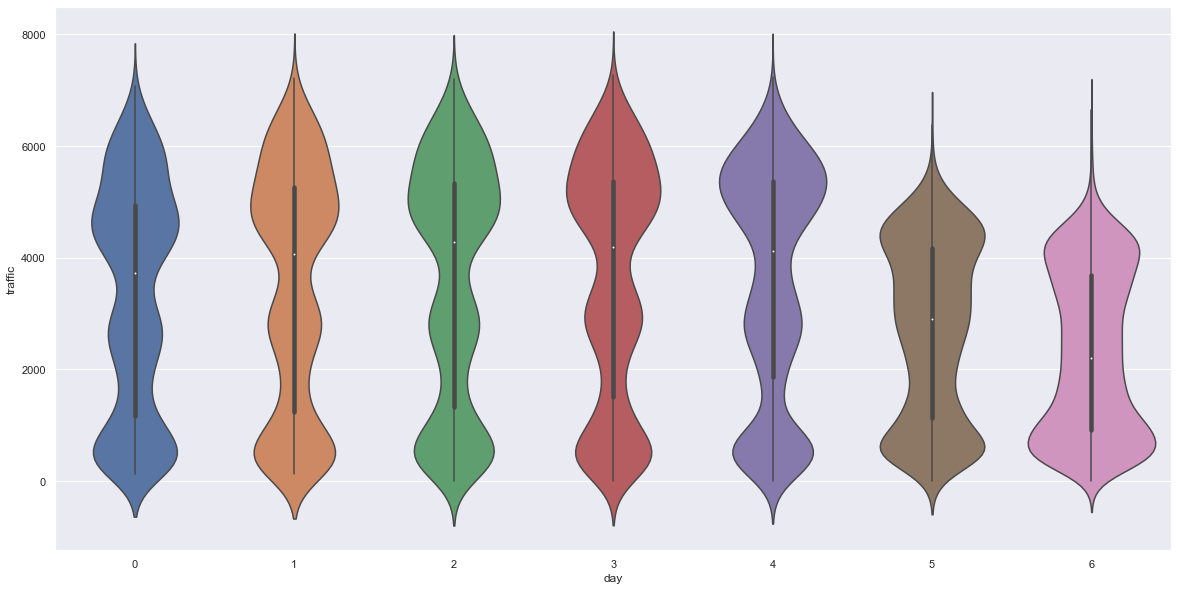

In [95]:
ax = sns.violinplot(x = traffic.day, y = traffic.traffic)

When it comes to comparing the distribution of traffic by day of the week, there is no noticeable difference between working days (Monday to Friday). However, a decrease in traffic is clearly visible on Saturdays and Sundays. This justifies the use of the variable informing whether it is the weekend. 

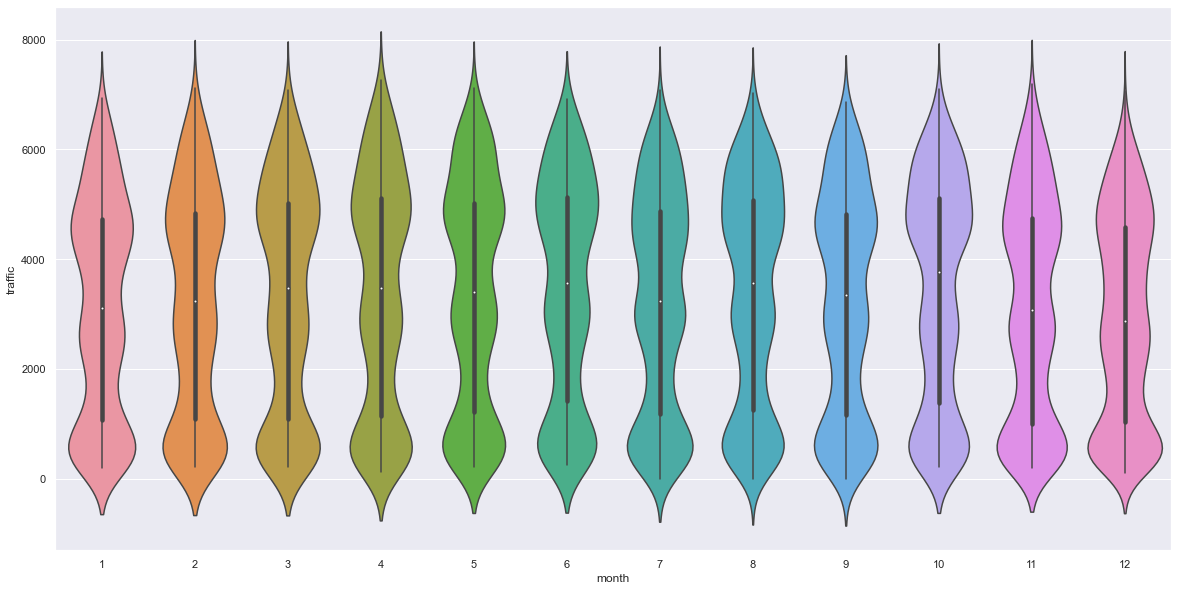

In [96]:
ax = sns.violinplot(x = traffic.month, y = traffic.traffic)

Comparing the distribution of the traffic variable by each month of the year, we do not notice a significant change in traffic volume during the winter or summer months. This may be confirmed by the fact that people work all year round, and single anomalies related to the increase of snowfall, slippery roads, or the occurrence of storms in summer are impossible to detect. 

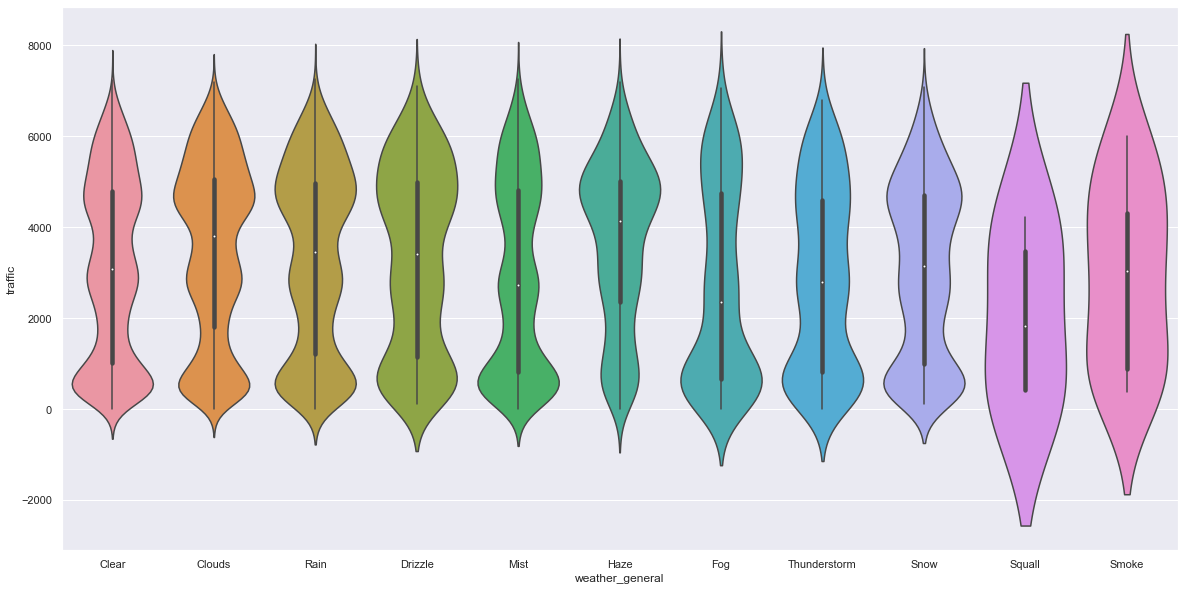

In [97]:
ax = sns.violinplot(x = traffic.weather_general, y = traffic.traffic, scale = "width")

The last statement is the relationship of the variable traffic depending on weather conditions (weather_general). Only Squall and Smoke differ from the other levels. However, as these two levels are the least numerous, they are included in Rain and Fog. 

## Pairplot between all numerical variables

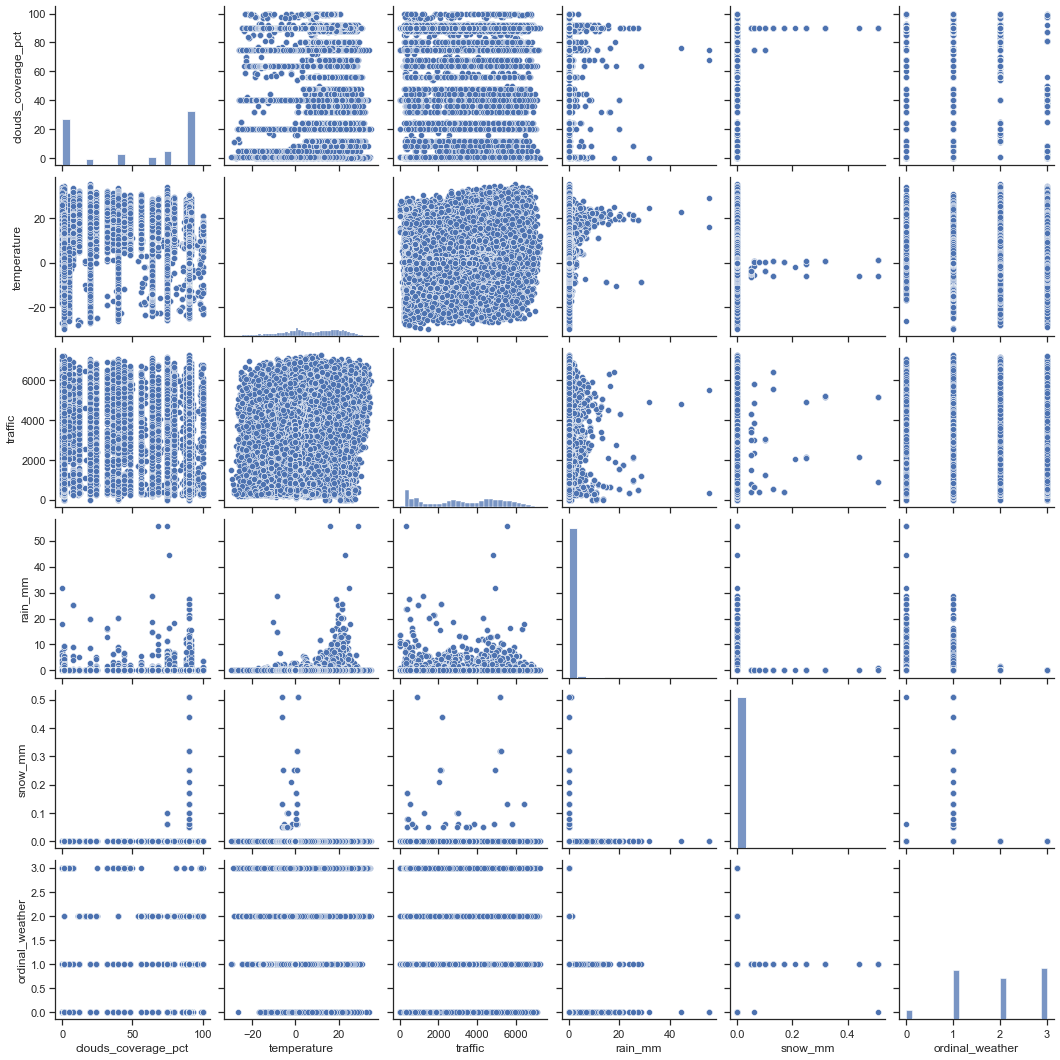

In [100]:
sns.set_theme(style="ticks")
sns.pairplot(traffic[['clouds_coverage_pct', 'temperature', 'traffic','rain_mm','snow_mm', 'ordinal_weather']])

The combination of all numeric variables with continuous variables can be seen in the pairplot diagram. 

## Deletion of observations equal to 0 for traffic and deletion of unnecessary variables

Because for regression our task is to estimate machine learning models with the smallest possible value of the cost function MAPE (Mean Absolute Percentage Error), unfortunately we have to remove observations that take the value 0 for the traffic variable. This is because the formula for MAPE has the value of the actual observation in the denominator, which leads to the situation that when we have a reading of 0 the MAPE cost function explodes to infinity. 


In [101]:
traffic = traffic[traffic['traffic'] != 0]
traffic = traffic[traffic['snow_mm'] == 0]
traffic = traffic[traffic['rain_mm'] == 0]
traffic = traffic.drop(columns = ['date_time', 'weather_general', 'weather_detailed', 
                                  'month', 'year', 'day', 'hour', 'rain_mm','snow_mm','hour_interval'])



## Division of the training set into training and test subsets

The breakdown of the training set is shown below. We divide our original training set into **85% training** observations and **15% test** observations to check the performance and effectiveness of the proposed models. 

In [36]:
train_x, test_x, train_y, test_y = train_test_split(traffic.loc[:,traffic.columns!='traffic'], traffic.traffic, test_size=0.15, random_state=50)

After division, the training and test sets have the following sizes.

In [37]:
print('Shape of train_x:', train_x.shape, end = '\n')
print('Shape of train_y:', train_y.shape, end = '\n')
print('Shape of test_x:', test_x.shape, end = '\n')
print('Shape of test_y:', test_y.shape)

Shape of train_x: (22845, 60)
Shape of train_y: (22845,)
Shape of test_x: (4032, 60)
Shape of test_y: (4032,)


## Mutual info

Before we move on to the modelling section let's have a look at the relationship of a single variable to the traffic variable under study. For this purpose you can use a statistic called Mutual Info. This statistic measures the dependence of one variable on another. The value of this statistic is close to zero, then we can see no dependency (variables are independent), while the observed values are much higher than zero, then we can conclude that there is a dependency (dependent variables). 

- High dependence variables: _clouds_coverage_pct_, _is_weekend_, _0-6_, _6-12_, _12-18_, _18-24_, _ordinal_weather_, _Clear_, _Clouds_, 
- Low or none dependence variables: _January_, _February_, _March_, _April_, _May_, _June_, ..., _December_, _Hour_0_, ..., _Hour_23_.

In [77]:
from scipy import stats
from sklearn import feature_selection

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

minfos=[]

for var in traffic.columns:
    if var in ['temperature', 'traffic']:
        continue
    print("\n", var)
    print("Pearson", np.round(stats.pearsonr(traffic.traffic, traffic[var]), 4))
    print("Mutual info", np.round(feature_selection.mutual_info_classif(traffic[var].values.reshape(-1,1),
                                                               traffic.traffic.values), 4))
    minfos.append(feature_selection.mutual_info_classif(traffic[var].values.reshape(-1,1),
                                                        traffic.traffic.values))
    print("Chi2", np.round(feature_selection.chi2(traffic[var].values.reshape(-1,1),
                                         traffic.traffic.values), 4))
    print("Anova", np.round(feature_selection.f_classif(traffic[var].values.reshape(-1,1),
                                                traffic.traffic.values), 4))




 clouds_coverage_pct
Pearson [0.0357 0.    ]
Mutual info [0.285]
Chi2 [[208532.4742]
 [     0.    ]]
Anova [[1.0486]
 [0.0092]]

 is_weekend
Pearson [-0.2222  0.    ]
Mutual info [0.4993]
Chi2 [[6895.1787]
 [   0.    ]]
Anova [[1.8066]
 [0.    ]]

 January
Pearson [-0.018   0.0032]
Mutual info [0.0084]
Chi2 [[6.1088153e+03]
 [9.9580000e-01]]
Anova [[1.0415]
 [0.0218]]

 February
Pearson [-0.0082  0.1764]
Mutual info [0.0083]
Chi2 [[6.2390547e+03]
 [9.2720000e-01]]
Anova [[1.0683e+00]
 [5.0000e-04]]

 March
Pearson [-3.000e-04  9.565e-01]
Mutual info [0.0138]
Chi2 [[6.1971531e+03]
 [9.6660000e-01]]
Anova [[1.0576]
 [0.0027]]

 April
Pearson [0.0209 0.0006]
Mutual info [0.0023]
Chi2 [[6.3758693e+03]
 [5.9260000e-01]]
Anova [[1.1046]
 [0.    ]]

 May
Pearson [0.0184 0.0025]
Mutual info [0.0137]
Chi2 [[6.1955385e+03]
 [9.6770000e-01]]
Anova [[1.0744e+00]
 [2.0000e-04]]

 June
Pearson [0.027 0.   ]
Mutual info [0]
Chi2 [[6.1635515e+03]
 [9.8370000e-01]]
Anova [[1.0342]
 [0.0477]]

 July
Pe

# 4. Modelling

In our analysis, we would like to present the following models and compare their effectiveness in predicting values for the variable traffic:
- Linear Regression
- Random Forest Regressor
- Elastic Net
- Support Vector Regressor
- K Nearest Neighbours Regressor
- Lasso
- Tweedie Regressor
- Gradient Boosting Regressor
- LightGBM with Optuna Optimizer

Most of the models were run through the so-called **Pipeline**. Before running the model learning itself, we also used the **RobustScaler()** functions to scale the data using the median and the interquartile deviation (IQR). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

Additionally, for some of the available algorithms, we applied the **GridSearchCV()** and **RandomizedSearchCV()** algorithms to tune the hyperparameters of the machine learning models. This allows us to select from among classes of models the one that achieves the lowest MAPE cost function value. 

In [38]:
mapeOfModels = [] # list to store mape results of the models

## Linear Regression

For the linear regression model with normalised variables we obtained a MAPE of 61.65%, which for such a basic model gives satisfactory results. Below we can take a look at how our estimated values of the traffic variable behave in comparison with the actual readings. An R-square of 82.5% also explains 82.5% of the variation in the traffic variable to a greater extent. 

In [39]:
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(train_x, train_y)

y_pred = lin_reg.predict(test_x)

print(f'MAPE: {round(mean_absolute_percentage_error(test_y, y_pred) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(test_y, y_pred)}')
print(r2_score(test_y, y_pred))
print(y_pred.reshape(-1,1))
print(test_y)

mapeOfModels.append((round(mean_absolute_percentage_error(test_y, y_pred) * 100, 4),'LinearRegression'))

MAPE: 61.6471%
MAE: 606.1984126984127
0.8257185633078699
[[3776.]
 [4792.]
 [4674.]
 ...
 [4564.]
 [4900.]
 [5189.]]
16864    3586
1018     5299
24021    4563
9878      771
7962     4418
         ... 
23375    5855
18348    3118
27379    4609
6229     6189
18195    2640
Name: traffic, Length: 4032, dtype: int64


## Random Forest Regressor

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Our random forest model achieved a MAPE score of 27.78% which gave a really satisfactory result. Unfortunately, this is not a method learned in class and, as we will see later, did not get the lowest MAPE score, so we do not use these estimations. The best random forest model through RandomizedSearchCV obtained parameters:
- max_features = 12
- n_estimators = 3

In [40]:
pip_forest = Pipeline([("scaler", RobustScaler()),
                        ("classifier",RandomForestRegressor(random_state=997))])

param_grid = [
    {'classifier__n_estimators': [3, 10, 15, 20, 30], 'classifier__max_features': [2, 4, 6, 8,12]},
    {'classifier__bootstrap': [False], 'classifier__n_estimators': [3, 10, 15,20,25, 30], 'classifier__max_features': [2, 4, 6, 8,12]}
  ]


grid_search = RandomizedSearchCV(pip_forest, param_grid, cv=3, n_iter=100,
                           scoring = make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                           return_train_score=True)
grid_search.fit(train_x, train_y)

best_forest = grid_search.best_estimator_ #RandomForestRegressor(bootstrap=False, max_features=3, n_estimators=3, random_state=42)
best_forest.fit(train_x, train_y)
y_forest = best_forest.predict(test_x)

print(f'MAPE: {round(mean_absolute_percentage_error(test_y, y_forest) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(test_y, y_forest)}')

MAPE: 27.784%
MAE: 344.0429480820106


In [41]:
best_forest = grid_search.best_estimator_ #RandomForestRegressor(bootstrap=False, max_features=12, n_estimators=3, random_state=997))
best_forest.fit(train_x, train_y)
y_forest = best_forest.predict(test_x)

print(f'MAPE: {round(mean_absolute_percentage_error(test_y, y_forest) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(test_y, y_forest)}')
mapeOfModels.append((round(mean_absolute_percentage_error(test_y, y_forest) * 100, 4),'RandomForestRegressor'))

MAPE: 27.784%
MAE: 344.0429480820106


## ElasticNet

The ElasticNet model is a simple linear regression model with regularisation through the L1 and L2 parameters. As we have learned about Lasso and Ridge regressions in this class, ElasticNet may also be one of the models used in this class. Unfortunately, the value of the MAPE cost function for this presented model was not much better than the usual linear regression and was equal to 61.26%. 

In [42]:
pip_elastic = Pipeline([("scaler", RobustScaler()),
                        ("classifier",ElasticNet(random_state=997))])

grid = dict()
grid['classifier__alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['classifier__l1_ratio'] = np.arange(0, 1, 0.2)

grid_search_2 = RandomizedSearchCV(pip_elastic, grid, cv=3, n_iter = 100,
                           scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                           return_train_score=True)

grid_search_2.fit(train_x, train_y)


best_elastic = grid_search_2.best_estimator_ #RandomForestRegressor(bootstrap=False, max_features=3, n_estimators=3, random_state=42)
best_elastic.fit(train_x, train_y)

y_elastic = best_elastic.predict(test_x)

print(f'MAPE: {round(mean_absolute_percentage_error(test_y, y_elastic) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(test_y, y_elastic)}')

MAPE: 61.2677%
MAE: 603.9216728702429


In [104]:
x = grid_search_2.best_estimator_.fit(train_x, train_y)
y_elastic = x.predict(test_x)

print(f'MAPE: {round(mean_absolute_percentage_error(test_y, y_elastic) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(test_y, y_elastic)}')

mapeOfModels.append((round(mean_absolute_percentage_error(test_y, y_elastic) * 100, 4),'ElasticNet'))

MAPE: 61.2677%
MAE: 603.9216728702429


## Support Vector Regressor

In class, we used Support Vector Machines in correctly separating observations about whether the person being examined is currently insured. For regression this also works well enough and our own grid search found that for kernel = 'linear' the smallest MAPE value was obtained for a parameter value of C = 100 equal to 50.77%. As we will see later this is also not a satisfactory result compared to other models. 

In [45]:
for c in [0.1, 1, 10, 100]:
    
    svr = SVR(C=c, kernel='linear')
    svr.fit(train_x, train_y)

    y_SVR = svr.predict(test_x)
    print('Value for C:',c)
    print(f'MAPE: {round(mean_absolute_percentage_error(test_y, y_SVR) * 100, 4)}%')
    print(f'MAE: {mean_absolute_error(test_y, y_SVR)}')


Value for C: 0.1
MAPE: 203.1887%
MAE: 1333.982981712389
Value for C: 1
MAPE: 73.7624%
MAE: 694.4092001059929
Value for C: 10
MAPE: 51.8253%
MAE: 568.1317720119458
Value for C: 100
MAPE: 50.7774%
MAE: 561.7810861649792


In [46]:
svr = SVR(C=100, kernel='linear')
svr.fit(train_x, train_y)

y_SVR = svr.predict(test_x)

mapeOfModels.append((round(mean_absolute_percentage_error(test_y, y_SVR) * 100, 4),'SVR'))

## K Nearest Neighbours Regressor

Regression based on k-nearest neighbors.

The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set. Source: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

As the name suggests, the algorithm decides into which group to classify the studied observation by giving it an appropriate traffic value based on similar characteristics. KNN was a very promising algorithm, obtaining a MAPE cost function value of 32.8%. The GridSearchCV used found that the smallest MAPE value this algorithm took for:
- n_neighbors = 3

In [47]:
pip_neigh = Pipeline([("scaler", RobustScaler()),
                        ("classifier", KNeighborsRegressor())])

parameters = {"classifier__n_neighbors": range(2, 20)}

gridsearch = GridSearchCV(pip_neigh, parameters, cv=3,
                           scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                           return_train_score=True)

gridsearch.fit(train_x, train_y)

knn_predicted = gridsearch.best_estimator_.predict(test_x)

print(f'MAPE: {round(mean_absolute_percentage_error(test_y, knn_predicted) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(test_y, knn_predicted)}')

mapeOfModels.append((round(mean_absolute_percentage_error(test_y, knn_predicted) * 100, 4),'KNN'))

MAPE: 32.8019%
MAE: 370.6324404761905


## Lasso

Linear Model trained with L1 prior as regularizer (aka the Lasso).

Like linear regression and ElasticNet before it, it creates a linear model with a regulariser who appropriately dictates the model for the use of insignificant variables. The Lasso model gave us a MAPE of 61.38%, which is comparable to linear regression and ElasticNet.

In [48]:
from sklearn import linear_model
pip_Lasso = Pipeline([("scaler", RobustScaler()),
                        ("classifier", linear_model.Lasso())])

lasso_alphas = np.linspace(0, 0.2, 21)
grid = dict()
grid['classifier__alpha'] = lasso_alphas

grid_search_Lasso = GridSearchCV(pip_Lasso, grid, cv=3,
                           scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                           return_train_score=True)
grid_search_Lasso.fit(train_x, train_y)
y_reg = grid_search_Lasso.best_estimator_.predict(test_x)

print(f'MAPE: {round(mean_absolute_percentage_error(test_y, y_reg) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(test_y, y_reg)}')

mapeOfModels.append((round(mean_absolute_percentage_error(test_y, y_reg) * 100, 4),'Lasso'))

MAPE: 61.3846%
MAE: 604.1177804699292


## Tweedie Regressor

Generalized Linear Model with a Tweedie distribution.

This estimator can be used to model different GLMs depending on the power parameter, which determines the underlying distribution.

Our model achieved a moderate MAPE score of 45.88% (better than linear regression, ElasticNet or Lasso), but worse than KNN or Random Forest. 

In [50]:
reg = TweedieRegressor(power=1, alpha=0.1, link='log')
reg.fit(train_x, train_y)
y_reg = reg.predict(test_x)

print(f'MAPE: {round(mean_absolute_percentage_error(test_y, y_reg) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(test_y, y_reg)}')

mapeOfModels.append((round(mean_absolute_percentage_error(test_y, y_reg) * 100, 4),'TweedieRegressor'))

MAPE: 45.8844%
MAE: 535.648143185541


## Gradient Boosting Regressor

Gradient Tree Boosting or Gradient Boosted Decision Trees (GBDT) is a generalization of boosting to arbitrary differentiable loss functions. Source: https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting

The algorithm seeks a better global minimum of the cost function by adjusting the available parameters: 
- n_estimators
- max_depth
- min_samples_split
- learning_rate

This model achieved a MAPE of 37.78%, which is also a moderately good result when compared to others. In addition, we note the Feature Importance below. From the graph we can see that some of the most significant variables were the hourly intervals from 24 to 6 and from 18 to 24, as well as whether it is currently the weekend. 

MAPE: 37.7817%
MAE: 386.62310716167445


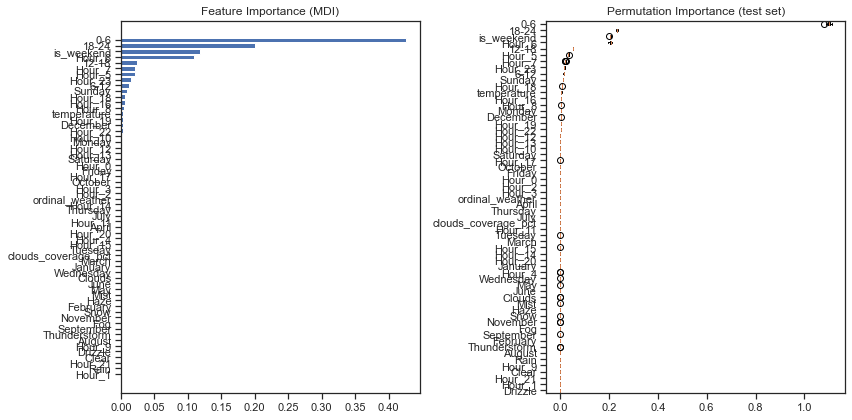

In [51]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = GradientBoostingRegressor(**params)
reg.fit(train_x, train_y)

y_reg = reg.predict(test_x)

print(f'MAPE: {round(mean_absolute_percentage_error(test_y, y_reg) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(test_y, y_reg)}')
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(train_x.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, train_x, train_y, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(train_x.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

mapeOfModels.append((round(mean_absolute_percentage_error(test_y, y_reg) * 100, 4),'GradientBoostingRegressor'))

## LightGBM

Similar to XGBoost, LightGBM (by Microsoft) is a distributed high-performance framework that uses decision trees for ranking, classification, and regression tasks.

The advantages are as follows:
- Faster training speed and accuracy resulting from LightGBM being a histogram-based algorithm that performs bucketing of values (also requires lesser memory)
- Also compatible with large and complex datasets but is much faster during training
- Support for both parallel learning and GPU learning

Source: https://neptune.ai/blog/xgboost-vs-lightgbm & https://lightgbm.readthedocs.io/en/latest/


MAPE: 27.0738%
MAE: 287.1861314765379


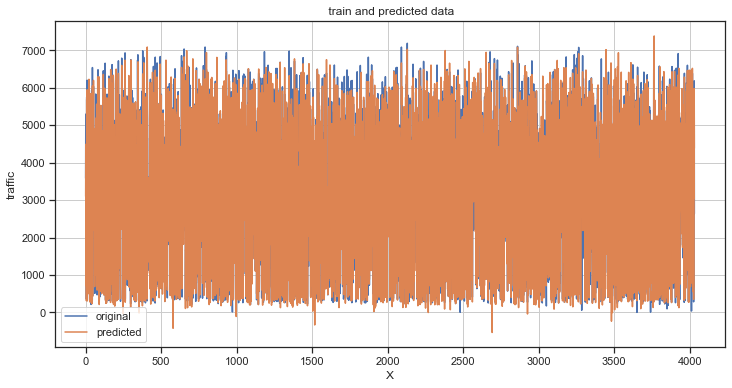

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

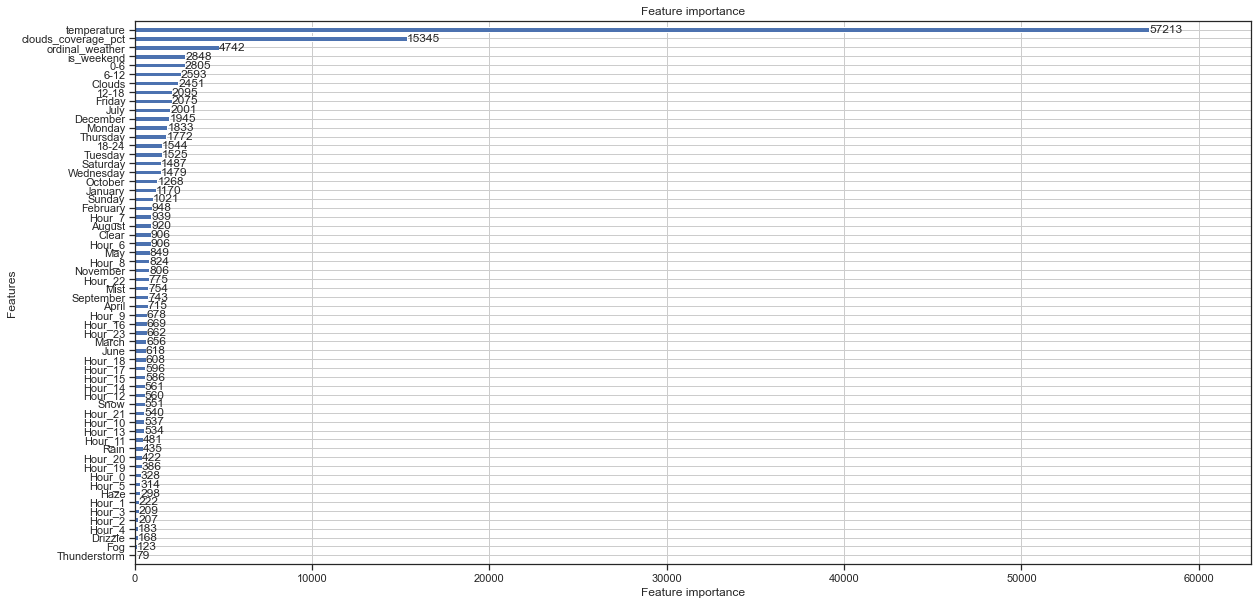

In [52]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'n_estimators': 900,
    'learning_rate': 0.3,
    'objective': 'regression',
    'num_leaves': 4096,
    'max_depth' : 12,
    'metric': {'l2','l1'},
    'verbose': -1
}

lgb_train = lgb.Dataset(train_x, train_y)


model = lgb.train(params,
                 train_set=lgb_train)
                 #valid_sets=y_train,
                 #early_stopping_rounds=30)


lgm_pred = model.predict(test_x)


print(f'MAPE: {round(mean_absolute_percentage_error(test_y, lgm_pred) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(test_y, lgm_pred)}')

x_ax = range(len(test_y))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, test_y, label="original")
plt.plot(x_ax, lgm_pred, label="predicted")
plt.title(" train and predicted data")
plt.xlabel('X')
plt.ylabel('traffic')
plt.legend(loc='best',fancybox=True, shadow=False)
plt.grid(True)
plt.show()  

lgb.plot_importance(model, height=.5)



## LightGBM with Optuna Optimizer

Optuna is An open source hyperparameter optimization framework to automate hyperparameter search.

LightGBM together with Optuna is currently one of the fastest boosting algorithms. This is indicated by many benchmarks available on the internet in comparison with XGBoost. Optuna creates a study in which the algorithm finds the global minimum of the cost function in a very fast and economical way via a gradient function. 

This combination of the two algorithms allowed us to obtain the lowest possible MAPE of 23.62%, and this learned model will be used further for prediction on the test set. 

Looking at the Feature Importance for this model we can see that it was, however, the level of temperature, the level of cloud cover, the weather conditions and whether it was currently the weekend that most influenced the algorithm's decision making. 

In [55]:
def objective(trial):
    dtrain = lgb.Dataset(train_x, label=train_y)
 
    param = {
        'objective': 'regression',
        'metric': {'l2','l1'},
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 4096),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'task': 'train', 
        'boosting': 'gbdt',
        'verbose': -1
    }
 
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(test_x)
    mape = sklearn.metrics.mean_absolute_percentage_error(test_y, preds)
    return mape
 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-06-03 10:36:14,929] A new study created in memory with name: no-name-c5a79431-fbb1-421c-973b-a4dce1120798
[I 2022-06-03 10:36:16,029] Trial 0 finished with value: 0.28892860122044783 and parameters: {'n_estimators': 590, 'learning_rate': 0.9573212602687539, 'num_leaves': 1849, 'max_depth': 8}. Best is trial 0 with value: 0.28892860122044783.
[I 2022-06-03 10:36:16,171] Trial 1 finished with value: 0.4120748099361683 and parameters: {'n_estimators': 270, 'learning_rate': 0.035762025271736324, 'num_leaves': 3333, 'max_depth': 3}. Best is trial 0 with value: 0.28892860122044783.
[I 2022-06-03 10:36:16,339] Trial 2 finished with value: 0.6327079759522667 and parameters: {'n_estimators': 478, 'learning_rate': 0.012987429229243804, 'num_leaves': 3969, 'max_depth': 2}. Best is trial 0 with value: 0.28892860122044783.
[I 2022-06-03 10:36:16,705] Trial 3 finished with value: 0.3060208613356925 and parameters: {'n_estimators': 911, 'learning_rate': 0.03578265733453882, 'num_leaves': 3283

[I 2022-06-03 10:36:43,286] Trial 33 finished with value: 0.2573513765508389 and parameters: {'n_estimators': 752, 'learning_rate': 0.21265502181845963, 'num_leaves': 519, 'max_depth': 8}. Best is trial 32 with value: 0.23627086271513884.
[I 2022-06-03 10:36:44,039] Trial 34 finished with value: 0.24418890257140033 and parameters: {'n_estimators': 499, 'learning_rate': 0.2907586042048352, 'num_leaves': 84, 'max_depth': 8}. Best is trial 32 with value: 0.23627086271513884.
[I 2022-06-03 10:36:45,180] Trial 35 finished with value: 0.25866221769648257 and parameters: {'n_estimators': 682, 'learning_rate': 0.46158905529752303, 'num_leaves': 874, 'max_depth': 8}. Best is trial 32 with value: 0.23627086271513884.
[I 2022-06-03 10:36:45,729] Trial 36 finished with value: 0.24315778614708414 and parameters: {'n_estimators': 415, 'learning_rate': 0.1520128975261635, 'num_leaves': 441, 'max_depth': 7}. Best is trial 32 with value: 0.23627086271513884.
[I 2022-06-03 10:36:46,226] Trial 37 finishe

[I 2022-06-03 10:37:09,350] Trial 66 finished with value: 0.2412679115227688 and parameters: {'n_estimators': 829, 'learning_rate': 0.16601252163191482, 'num_leaves': 2282, 'max_depth': 7}. Best is trial 32 with value: 0.23627086271513884.
[I 2022-06-03 10:37:11,128] Trial 67 finished with value: 0.24848437355071626 and parameters: {'n_estimators': 919, 'learning_rate': 0.0753972798467698, 'num_leaves': 2338, 'max_depth': 8}. Best is trial 32 with value: 0.23627086271513884.
[I 2022-06-03 10:37:12,115] Trial 68 finished with value: 0.24898347180547528 and parameters: {'n_estimators': 844, 'learning_rate': 0.10598108812322653, 'num_leaves': 2416, 'max_depth': 6}. Best is trial 32 with value: 0.23627086271513884.
[I 2022-06-03 10:37:13,282] Trial 69 finished with value: 0.2390514584819428 and parameters: {'n_estimators': 815, 'learning_rate': 0.2109233670260973, 'num_leaves': 345, 'max_depth': 7}. Best is trial 32 with value: 0.23627086271513884.
[I 2022-06-03 10:37:14,514] Trial 70 fini

[I 2022-06-03 10:37:52,302] Trial 99 finished with value: 0.2446495016539613 and parameters: {'n_estimators': 854, 'learning_rate': 0.3075323578792076, 'num_leaves': 102, 'max_depth': 5}. Best is trial 32 with value: 0.23627086271513884.


Number of finished trials: 100
Best trial: {'n_estimators': 733, 'learning_rate': 0.1579544387440169, 'num_leaves': 468, 'max_depth': 8}


MAPE: 23.6271%
MAE: 270.9755703741944


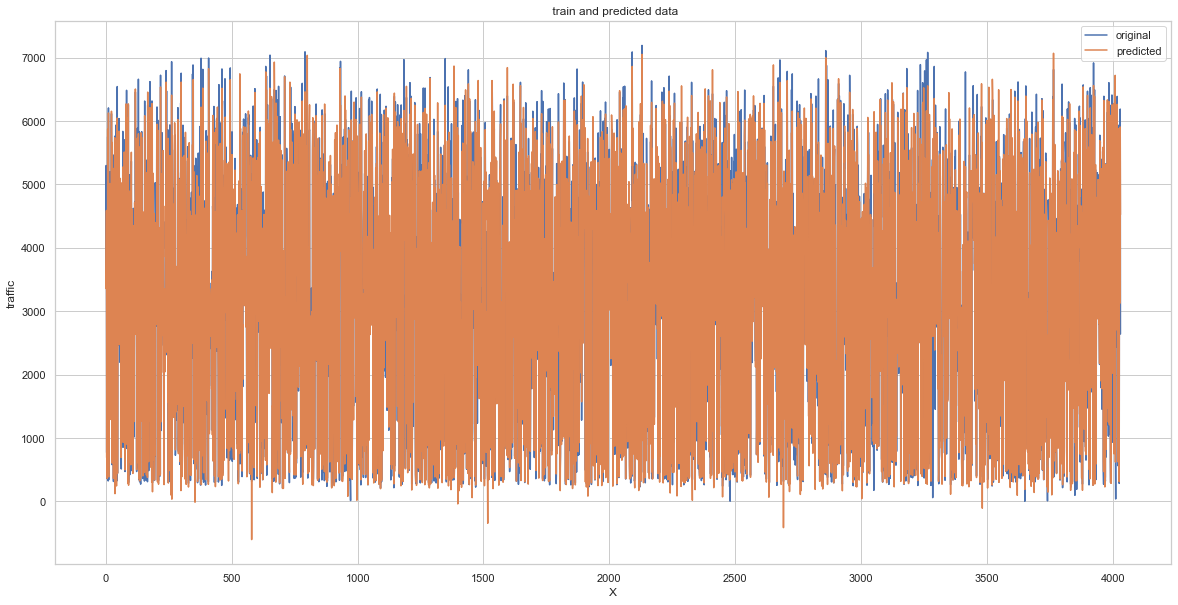

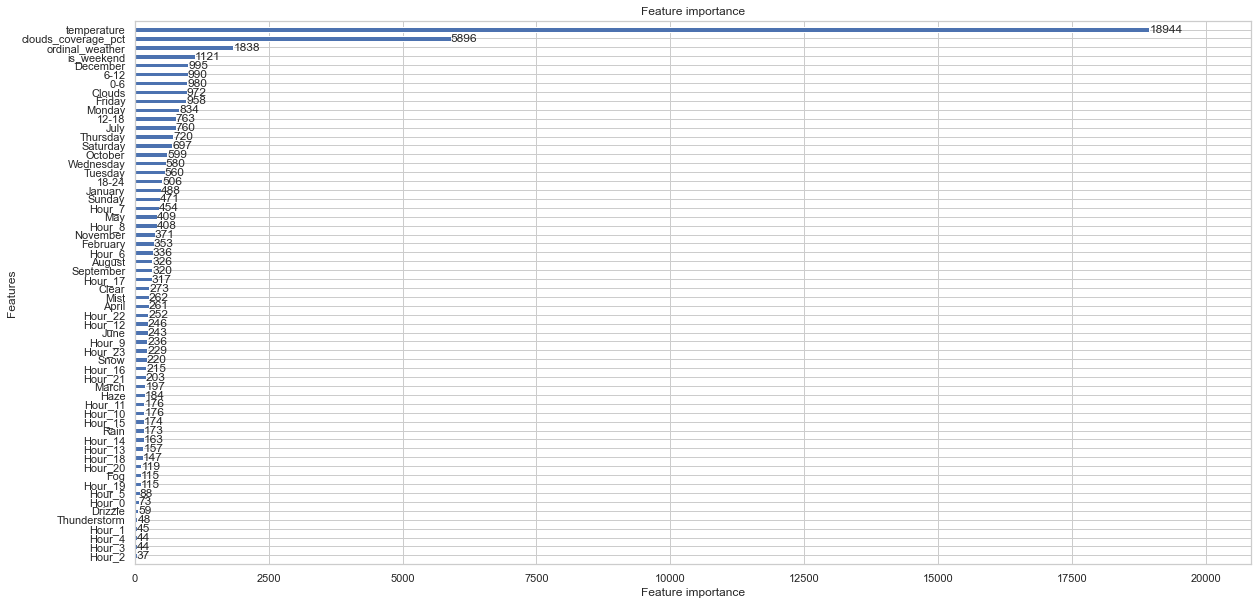

In [75]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'n_estimators': study.best_trial.params['n_estimators'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'objective': 'regression',
    'num_leaves': study.best_trial.params['num_leaves'],
    'max_depth' : study.best_trial.params['max_depth'],
    'metric': {'l2','l1'},
    'verbose': -1
}

lgb_train = lgb.Dataset(train_x, train_y)


model = lgb.train(params,
                 train_set=lgb_train)
                 #valid_sets=y_train,
                 #early_stopping_rounds=30)


lgm_pred = model.predict(test_x)

print(f'MAPE: {round(mean_absolute_percentage_error(test_y, lgm_pred) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(test_y, lgm_pred)}')

x_ax = range(len(test_y))
plt.figure(figsize=(20, 10))
plt.plot(x_ax, test_y, label="original")
plt.plot(x_ax, lgm_pred, label="predicted")
plt.title(" train and predicted data")
plt.xlabel('X')
plt.ylabel('traffic')
plt.legend(loc='best',fancybox=True, shadow=False)
plt.grid(True)
plt.show()  

lgb.plot_importance(model, height=.5)

mapeOfModels.append((round(mean_absolute_percentage_error(test_y, lgm_pred) * 100, 4),'lightgbmWithOptuna'))

## Summary of the evaluation of the models

Below we can look at what effectiveness our proposed models have achieved. There is a clear advantage for algorithms such as **Random Forest** and **LightGBM with Optuna Optimizer**, which obtained **27.78%** and **23.62%** MAPE respectively.
Finally, we will run our predictions on the additionally proposed model **LightGBM with Optuna Optimizer**, as it achieved the lowest MAPE cost function value.

In [111]:
mapeOfModels
mapeOfModels.sort()

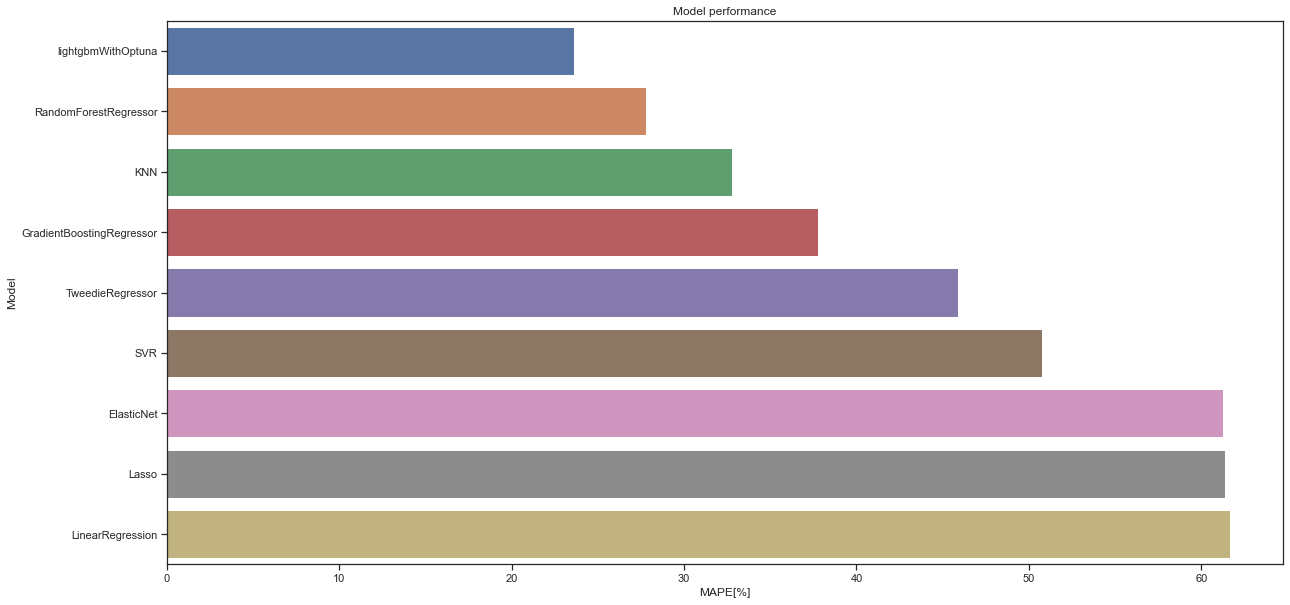

In [112]:
res = [[ i for i, j in mapeOfModels ],
       [ j for i, j in mapeOfModels ]]
ax = sns.barplot(x = res[0], y = res[1])
ax.set(xlabel='MAPE[%]', ylabel='Model')
plt.title("Model performance")
plt.show()

In contrast, the machine learning models presented in class such as **Linear Regression**, **SVR**, **KNN** and **Lasso** scored moderately for the MAPE statistic, with the KNN model performing best with a score of **32.8%**.

# 5. Prediction on test dataset

In [62]:
traffic_test = pd.read_csv('traffic_test.csv')

traffic_test = dayFromDate(traffic_test)
traffic_test = ordinal_whether(traffic_test)
traffic_test = weather_dummies_test(traffic_test)
traffic_test = outliers_correction(traffic_test)

In [63]:
traffic_test = traffic_test.drop(columns = ['date_time', 'weather_general', 'weather_detailed', 
                                  'month', 'year', 'day', 'hour', 'rain_mm','snow_mm','hour_interval'])

In [64]:
traffic_test.rename(columns={'1_x':'January', '2_x':'February', '3_x':'March', '4_x':'April',
                       '5_x':'May','6_x':'June','7_x':'July', '8_x':'August','9_x':'September',
                       '10_x':'November', '11_x':'October', '12_x':'December', '0_x':'Hour_0',
                       '1_y':'Hour_1','2_y':'Hour_2','3_y':'Hour_3','4_y':'Hour_4',
                       '5_y':'Hour_5','6_y':'Hour_6','7_y':'Hour_7','8_y':'Hour_8',
                       '9_y':'Hour_9','10_y':'Hour_10','11_y':'Hour_11','12_y':'Hour_12',
                       13:'Hour_13',14:'Hour_14',15:'Hour_15',16:'Hour_16',
                       17:'Hour_17',18:'Hour_18',19:'Hour_19',20:'Hour_20',
                       21:'Hour_21',22:'Hour_22',23:'Hour_23','0_y':'Monday',
                       1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}, inplace=True)

In [65]:
lgm_pred = model.predict(traffic_test)

<AxesSubplot:>

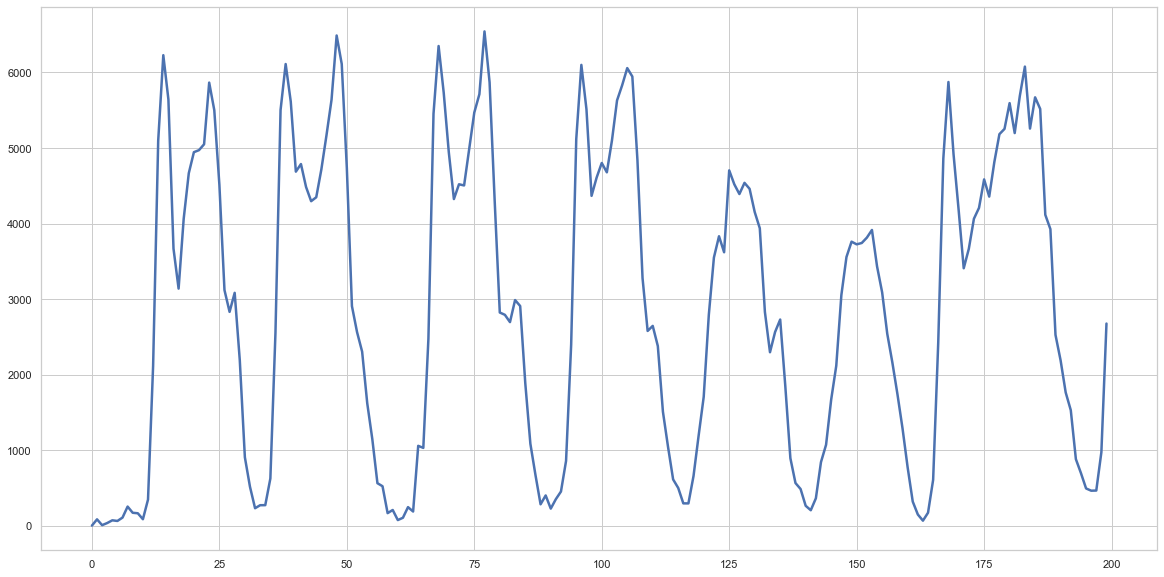

In [68]:
result = [x if x > 0 else x * (-1) for x in lgm_pred]
sns.set(rc = {'figure.figsize':(20,10)})
sns.set_theme(style="whitegrid")
sns.lineplot(data=result[:200],  palette="tab10", linewidth=2.5)

In [74]:
# Save results
submission = result
pd.DataFrame(submission).to_csv("final_results_reg.csv", header = None, index = None)